In [79]:
import os
from pathlib import Path
from math import log, sqrt, pi, exp, floor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date, timedelta
import numpy as np
from yahoo_fin import options
from yahoo_fin import stock_info as si

In [136]:
### American option pricers (Binomial Tree) ###
def binomial_american_option_pricer (optionType, S, K, t, t_q, r, q, vola, N, getTheta=False):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t:
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))

    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]
    
    option = np.zeros([N + 1, N + 1])

    if optionType == "Call":
        # Generate option prices recursively
        option[N, :] = np.maximum(np.zeros(N + 1), stock[N, :] - K)

        for n in range(N - 1, -1, -1):
            for j in range(n + 1):
                option[n, j] = (
                np.maximum(0, (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
                )
    elif optionType == "Put":
        # Generate option prices recursively
        option[N, :] = np.maximum(np.zeros(N + 1), K - stock[N, :])

        for n in range(N - 1, -1, -1):
            for j in range(n + 1):
                option[n, j] = (
                np.maximum(0, (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
                )
    else:
        print("UNRECOGNIZED OPTION TYPE")
    
    if getTheta==False:
        return option[0, 0]
    else:
        return (option[2, 1] - option[0, 0]) / (2 * t / N)

def binomial_delta(optionType, S, K, t, t_q, r, q, vola, N, h):
    return (
            binomial_american_option_pricer(optionType, S + h, K, t, t_q, r, q, vola, N)
            - binomial_american_option_pricer(optionType, S - h, K, t, t_q, r, q, vola, N)
    ) / (2*h)

def binomial_gamma(optionType, S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    return 2 / (u**2*S - d**2*S) * (
        (
            binomial_american_option_pricer(optionType, u**2*S, K, t, t_q, r, q, vola, N) -
            binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola, N)
        )
            /
        (
            u**2*S - S
        )
            - 
        (
            binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola, N) -
            binomial_american_option_pricer(optionType, d**2*S, K, t, t_q, r, q, vola, N)
        )
            /
        (
            S - d**2*S
        )
    )
def binomial_vega(optionType, S, K, t, t_q, r, q, vola, N, h):
    return (
            binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola + h, N)
            - binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola - h, N)
    ) / (2*h)

print(binomial_american_option_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=1.3759, N=10, optionType="Call"))
print(binomial_american_option_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0, N=10, optionType="Put"))

10.66759613104202
1.9908690669177695


In [116]:
### Binomial american implied volatility calculation formulas ###

def iv_binomial_american_option(optionType, S, K, t, t_q, r, q, N, market_price, a=0.01, b=2.0, xtol=1e-6):
    _optionType, _S, _K, _t, _t_q, _r, _q, _N, _market_price = optionType, S, K, t, t_q, r, q, N, market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _market_price - binomial_american_option_pricer(_optionType, _S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_american_option_pricer("Call", S, K, t, t_q, r, q, vola, N)
put_price = binomial_american_option_pricer("Put", S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_american_option("Call", S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_american_option("Put", S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

1.0532305534802595
1.0449373906009243
Make sure that 0.25000000000077693 is close to 0.25
Make sure that 0.25000000000077544 is close to 0.25


In [82]:
### Market data fetch ###

ticker = "spy"
option_series = datetime(2021, 10, 15)
chain = options.get_options_chain(ticker, option_series)
call_chain = chain["calls"]
put_chain = chain["puts"]
options.get_expiration_dates(ticker);
S = si.get_live_price("spy")

In [83]:
### Calculate time to expiration ###
expiration_date = option_series + timedelta(hours=16)
ex_dividend_date = datetime(2021, 9, 17)
minutes_in_a_year=365*24*60
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
t_q = floor((ex_dividend_date - datetime.now()).total_seconds() / 60 )/ minutes_in_a_year

In [84]:
pd.set_option('display.max_rows', 500) #Show n Dataframe rows
print(call_chain)
print(put_chain)

          Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0    SPY211015C00190000   2021-08-24 6:32PM EDT   190.0      219.60  261.62   
1    SPY211015C00195000   2021-08-24 6:32PM EDT   195.0      185.09  256.63   
2    SPY211015C00200000   2021-08-24 6:32PM EDT   200.0      227.46  251.61   
3    SPY211015C00210000   2021-08-24 6:32PM EDT   210.0      205.07  241.61   
4    SPY211015C00215000   2021-08-24 6:32PM EDT   215.0      171.93  236.61   
5    SPY211015C00220000   2021-08-24 6:32PM EDT   220.0      194.96  231.62   
6    SPY211015C00225000   2021-08-24 6:33PM EDT   225.0      201.79  226.63   
7    SPY211015C00230000   2021-08-24 6:33PM EDT   230.0      210.75  221.61   
8    SPY211015C00235000   2021-08-24 6:33PM EDT   235.0      203.40  216.61   
9    SPY211015C00240000   2021-08-24 6:33PM EDT   240.0      198.40  211.63   
10   SPY211015C00245000   2021-08-24 6:33PM EDT   245.0      196.10  206.63   
11   SPY211015C00250000   2021-08-24 6:33PM EDT   25

In [85]:
### Organize the data ###
call_chain["Mid Price"] = (call_chain["Ask"] - call_chain["Bid"])/2. + call_chain["Bid"]
put_chain["Mid Price"] = (put_chain["Ask"] - put_chain["Bid"])/2. + put_chain["Bid"]

data = {"Strike" : call_chain["Strike"],
        "CallPrice" : call_chain["Mid Price"]}
data_chain = pd.DataFrame(data)

#Combine call and put prices by strike
for i, row in call_chain.iterrows():
    data_chain.loc[i, 'PutPrice'] = next(iter(put_chain.loc[put_chain['Strike'] == row['Strike']]['Mid Price']), np.nan)
    
#Clean up data
for i, row in data_chain.iterrows():
    if data_chain.loc[i, 'CallPrice'] < 0.05 or data_chain.loc[i, 'PutPrice'] < 0.05:
        data_chain.drop(index=i, inplace=True)
data_chain.dropna(inplace=True)
data_chain.reset_index(drop=True, inplace=True)
print(data_chain)

     Strike  CallPrice  PutPrice
0     250.0    202.095     0.055
1     255.0    197.100     0.055
2     260.0    192.100     0.065
3     265.0    187.095     0.075
4     270.0    182.080     0.085
5     275.0    177.090     0.090
6     280.0    172.090     0.105
7     285.0    167.105     0.115
8     290.0    162.105     0.125
9     295.0    157.110     0.145
10    300.0    152.120     0.155
11    303.0    149.125     0.165
12    305.0    147.125     0.175
13    310.0    142.135     0.195
14    312.0    140.140     0.205
15    313.0    139.140     0.205
16    315.0    137.150     0.215
17    318.0    134.150     0.225
18    320.0    132.155     0.235
19    321.0    131.155     0.245
20    322.0    130.170     0.245
21    323.0    129.170     0.255
22    324.0    128.165     0.255
23    325.0    127.170     0.265
24    326.0    126.175     0.275
25    327.0    125.175     0.275
26    329.0    123.185     0.285
27    330.0    122.185     0.295
28    331.0    121.195     0.305
29    332.

In [87]:
### Calibrate r so that ATM vols are the same, q should be known ###
q = 1.3759 #dividend in dollars
r = 0.00575
N = 250

#Find strike where call and put prices are the closest
data_chain["PriceDelta"] = abs(data_chain["CallPrice"] - data_chain["PutPrice"])
minDiff = min(data_chain["PriceDelta"])
atm_strike = next(iter(data_chain.loc[data_chain["PriceDelta"] == minDiff]["Strike"]), np.nan)
atm_call_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["CallPrice"]), np.nan)
atm_put_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["PutPrice"]), np.nan)
print(atm_strike, atm_call_price, atm_put_price)

#Calculate ATM vols
iv_call = iv_binomial_american_option("Call", S, atm_strike, t, t_q, r, q, N, atm_call_price)
iv_put = iv_binomial_american_option("Put", S, atm_strike, t, t_q, r, q, N, atm_put_price)
print(iv_call, iv_put)

451.0 7.5649999999999995 7.8149999999999995
0.1229359453573382 0.12292233778601054


In [90]:
#Build volatility smile
data = {"Strike" : data_chain["Strike"],
        "CallImpliedVol" : 0,
        "PutImpliedVol" : 0,
        "CallDelta" : 0,
        "PutDelta" : 0
       }
vol_data = pd.DataFrame(data)
for i, row in data_chain.iterrows():
    #Compute implied volatility
    vol_data.loc[i, 'CallImpliedVol'] = iv_binomial_american_option("Call", S, row["Strike"], t, t_q, r, q, N, row["CallPrice"])
    vol_data.loc[i, 'PutImpliedVol'] = iv_binomial_american_option("Put", S, row["Strike"], t, t_q, r, q, N, row["PutPrice"])
    print(str(i) + "..", end="")
print("")
print("Done")

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..151..152..153..154..155..156..157..158..
Done


In [91]:
print(vol_data)

     Strike  CallImpliedVol  PutImpliedVol  CallDelta  PutDelta
0     250.0        0.805885       0.610760        NaN       NaN
1     255.0        0.782783       0.591394        NaN       NaN
2     260.0        0.758476       0.581216        NaN       NaN
3     265.0        0.732996       0.571237        NaN       NaN
4     270.0        0.704734       0.559764        NaN       NaN
5     275.0        0.685134       0.544147        NaN       NaN
6     280.0        0.662684       0.534859        NaN       NaN
7     285.0        0.645431       0.522467        NaN       NaN
8     290.0        0.623751       0.508385        NaN       NaN
9     295.0        0.603842       0.498810        NaN       NaN
10    300.0        0.584657       0.485176        NaN       NaN
11    303.0        0.572946       0.477976        NaN       NaN
12    305.0        0.564500       0.473813        NaN       NaN
13    310.0        0.545732       0.461999        NaN       NaN
14    312.0        0.538521       0.4579

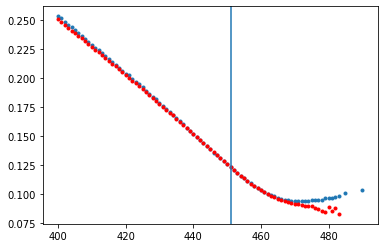

In [92]:
### Plot volatility data ###
x_min = 400
x_max = 495
plot_data = vol_data[(vol_data["Strike"] >= x_min) & (vol_data["Strike"] <= x_max)]
plt.plot(plot_data["Strike"], plot_data["CallImpliedVol"], '.')
plt.plot(plot_data["Strike"], plot_data["PutImpliedVol"], 'r.')
plt.autoscale(enable=True, axis='y')
plt.axvline(x=atm_strike)
plt.show()

In [ ]:
### Save to CSV file ###

#Point-out at-the-money strike
vol_data["At-the-money"] = (vol_data["Strike"] == atm_strike)

#Save data to CSV
now = datetime.now()
path = r"vols"
path = os.path.join(path, str(ticker))
series_path = r"series_" + str(expiration_date.year) + r"-" + str(expiration_date.month) + r"-" + str(expiration_date.day)
path = os.path.join(path, series_path)
Path(path).mkdir(parents=True, exist_ok=True)
file_name = str(ticker) + "_series_" + str(expiration_date.month) \
            + r"-" + str(expiration_date.day) + r"_" + str(now.year) + r"-" \
            + str(now.month) + r"-" + str(now.day) +  r".csv"
vol_data.to_csv(os.path.join(path, file_name), index=False)

In [140]:
#Calculate Greeks
K = atm_strike
vol = next(iter(vol_data.loc[vol_data["Strike"] == K]["PutImpliedVol"]), np.nan)
S = 100
r = 0.1
K = 100
q = 0
N = 10
vol = 0.15
t = 1
t_q = 0
delta = binomial_delta("Call", S, K, t, t_q, r, q, vol, N, 1)
gamma = binomial_gamma("Call", S, K, t, t_q, r, q, vol, N)
theta = binomial_american_option_pricer("Call", S, K, t, t_q, r, q, vol, N, getTheta=True)
vega = binomial_vega("Call", S, K, t, t_q, r, q, vol, N, 0.01)
print(delta, gamma, theta, vega)

0.767329877550365 0.019574461475444047 -9.064284478106277 29.378818264871853


451.79998779296875 450 0.1202435312024353 0.04170471841704718 0.00575 1.3759 0.12553188420375896 250
